In [1]:
from scipy import optimize
import numpy as np
import numpy as np
import random
import matplotlib.pyplot as plt

Since we are told that the steady state unemployment rate is 0.1, we can calculate that:


\begin{equation}
    \left[0.9 \text{ } 0.1 \right]
        \begin{bmatrix}
        0.9 & 0.1\\
        \alpha & 1 - \alpha\\
        \end{bmatrix} 
     = \left[0.9 \text{ } 0.1 \right]
\end{equation}

We can further derive that $\alpha=0.9$

In order to guess a value for $\bar{k}$ we'll find the steady state value of capital in a representative-agent economy. The first order conditions in our problem are:

$$
\begin{align*}
\frac{1}{r(\bar{k}) + w(\bar{k})\epsilon + (1 - \delta) k - k'} = \beta \mathbb{E}[\frac{\partial V(k', \epsilon; \bar{k})}{\partial k'}]
\end{align*}
$$

Using the envelope condition and envoking $k = k' = k''$ in the steady state, we have:

$$
\begin{align*}
k^{\ast} = \frac{1 - \beta(1 - \delta)(r(\bar{k}) + w(\bar{k})}{\beta(1 - \delta)^{2} - \beta (1 - \delta) - (1 - \delta) + 1}
\end{align*}
$$



## Steady state k

In [2]:
def get_k(k, p):
    part1 = (1 - p['beta']*(1 - p['delta'])*(p['alpha']*np.sign(k)*\
        np.abs(k)**(p['alpha'] - 1))*(1 - p['u'])**(1 - p['alpha']) + \
        (1 - p['alpha'])*np.sign(k)*np.abs(k)**(p['alpha'])*(1 - p['u'])**(-p['alpha']))
    
    part2 = (p['beta']*(1 - p['delta'])**(2) - p['beta']*(1 - p['delta']) - \
          (1 - p['delta']) + 1) - k
    return part1/part2

In [3]:
params = {'beta':0.96, 'delta':0.06, 'alpha':0.36, 'u':0.1}
print('Optimal k value: ', optimize.fsolve(get_k, 0.1, params)[0])

Optimal k value:  0.10382822181055043


## K bar

In [4]:
def k_bar(p):
    f = (p['alpha']*p['beta']/(1 - p['beta']*(1- p['delta'])))**(1/(1 - p['alpha']))
    return f

## Using VFI for Heteregenous Agents

In [5]:

def hetagents(kbar, p, N = 200):
    random.seed(0)
    threshold = 1e-10 
    
    k_low = 0.001
    k_high = 40
    kgrid = np.linspace(k_low, k_high, N)
    
    #Difference
    difference = 1
    
    
    #Set up value function matrices
    V_old = np.zeros((2,N))
    V_new = np.zeros_like(V_old)
    
    c = np.zeros_like(V_old)
    u = np.zeros_like(V_old)
    
    policyfun = np.zeros_like(V_old)
    
    p['u'] = 0.1
    transition = np.array([[0.9, 0.1], [0.9, 0.1]])
    itr = 1
    
    
    while (difference > threshold) and (itr <1000):
        for i in range(len(kgrid)):
            k = kgrid[i]
            
            r = p['alpha']*kbar**(p['alpha'] - 1)*(1 - p['u'])**(1 - p['alpha'])
            
            w = (1 - p['alpha'])*kbar**(p['alpha'])*(1 - p['u'])**(-p['alpha'])
            
            c[0, :] = r*k + w*1 + (1 - p['delta'])*k - kgrid
            c[1, :] = r*k + w*0 + (1 - p['delta'])*k - kgrid  
            
            obj = np.zeros_like(V_old)
            obj[c <= 0] = -99999999 
            obj[c > 0]= np.log(c[c > 0])
            
            V_almost = obj + p['beta']*(np.dot(transition, V_old))
            V_new[:, i] = np.amax(V_almost, axis = 1) 
            max_indicies = np.argmax(V_almost, axis = 1)
            policyfun[:, i] = kgrid[max_indicies]
            
        difference = np.linalg.norm(V_new - V_old)**(2)
        V_old = V_new.copy()
        itr += 1
        
    return policyfun, V_new, kgrid, itr

params = {'beta':0.96, 'delta':0.06, 'alpha':0.36, 'u':0.1}

kbar = k_bar(params)

policyfun, V_new, kgrid, itr = hetagents(kbar, params, N = 200)

In [6]:
itr

317

## Plotting the optimal decision rules

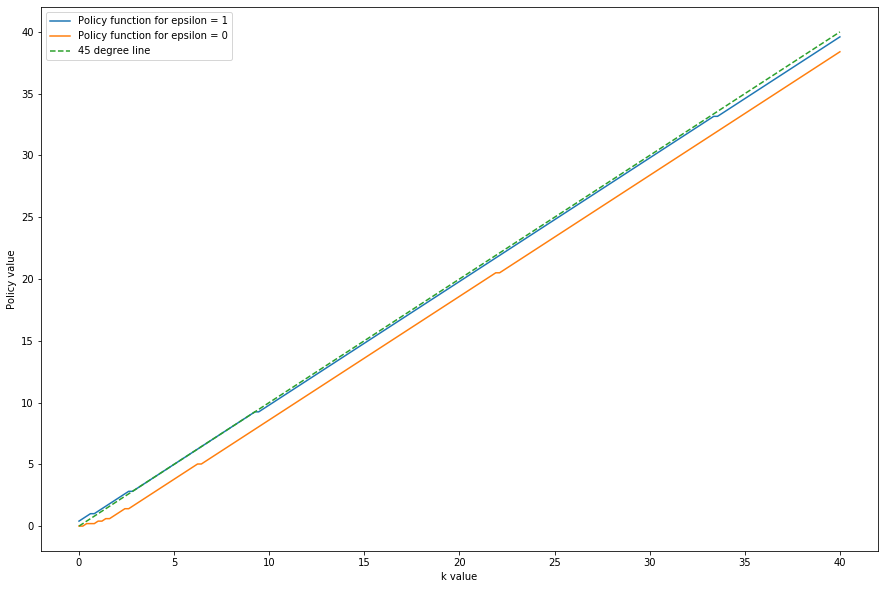

In [7]:
fig = plt.figure(figsize = (15, 10))
plt.plot(kgrid, policyfun[0, :], label = "Policy function for epsilon = 1")
plt.plot(kgrid, policyfun[1, :], label = "Policy function for epsilon = 0")
plt.plot(kgrid, kgrid, '--',label = "45 degree line")
plt.xlabel('k value')
plt.ylabel('Policy value')
plt.legend()
plt.show()

## Comparison to neoclassical growth

In [8]:
def comparisonSim(params, kbar, return_series = False, max_iter = 10000):
    random.seed(0)
    diff = 1
    iters=0
    c_series = np.zeros(10000)
    
    
    k_p, V_new, kgrid, _ =  hetagents(kbar, params, N = 400)
    k = random.choice(kgrid)
    c_series[0] = k

    for i in range(1, 10000):
        epsilon = np.random.binomial(1, 0.9, 1)
        if epsilon == 1:
            k = k_p[0, np.where(kgrid == k)[0]]
        else:
            k = k_p[1, np.where(kgrid == k)[0]]
        c_series[i] = k
        
    kbar_new = np.mean(c_series)
    eps = kbar_new - kbar
    kbar = kbar_new.copy()
    iters += 1
    print(iters, eps)
    if return_series == True:
        return eps, c_series
    else:
        return eps
            

In [9]:
def bisection(f,a,b):
    '''Approximate solution of f(x)=0 on interval [a,b] by the bisection method.

    Parameters
    ----------
    f : function
        The function for which we are trying to approximate a solution f(x)=0.
    a,b : numbers
        The interval in which to search for a solution. The function returns
        None if f(a)*f(b) >= 0 since a solution is not guaranteed.

    Returns
    -------
    x_N : number
        The midpoint of the Nth interval computed by the bisection method. The
        initial interval [a_0,b_0] is given by [a,b]. If f(m_n) == 0 for some
        midpoint m_n = (a_n + b_n)/2, then the function returns this solution.
        If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
        iteration, the bisection method fails and return None.
    '''
    max_iter, count = 250, 0 
    eps, threshold =100, 5e-1
    if f(a)*f(b) >= 0:
        print("Bisection method fails.")
        return None
    a_n = a
    b_n = b
    while (eps > threshold and count < max_iter): 
        m_n = (a_n + b_n)/2
        f_m_n = f(m_n)
        if f(a_n)*f_m_n < 0:
            a_n = a_n
            b_n = m_n
        elif f(b_n)*f_m_n < 0:
            a_n = m_n
            b_n = b_n
        elif f_m_n == 0:
            print("Found exact solution.")
            return m_n
        else:
            print("Bisection method fails.")
            return None
        count +=1
        eps = b_n - a_n 
    return (a_n + b_n)/2

In [10]:
kbar = k_bar(params)
f = lambda kbar: comparisonSim(params, kbar)

bisection(f, 0.1, 20)

1 39.89716297819549
1 -17.863775186466164
1 -8.449280595488723
1 39.89716297819549
1 34.68700093759398
1 39.89716297819549
1 -8.457952057894737
1 -5.395930080451127
1 34.673156672180454
1 32.467114940601505
1 34.671943669924815
1 -5.455046396992481
1 -4.081480916541354
1 32.52689289473685
1 -1.617614784962405
1 32.34255665112783


6.4742187499999995

In [11]:
eps, c_series = comparisonSim(params, 6.4742187499999995, return_series=True)

1 -0.048386893609021264


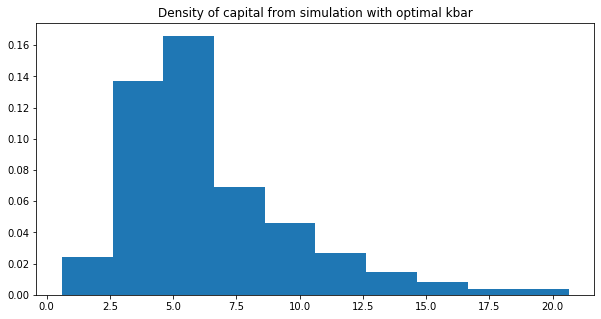

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Density of capital from simulation with optimal kbar')
ax.hist(c_series, density=True)
plt.show()